# **Đọc dữ liệu**

In [1]:
# ===========================================
# BBS Skyline Pipeline (GIỮ NGUYÊN LOGIC GỐC)
# Chỉ chỉnh cấu hình cho KHỚP FILE GỐC
# ===========================================
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, monotonically_increasing_id
import os

spark = (
    SparkSession.builder
    .appName("SkylineQueryWithCatBoostAndDelta")
    .config("spark.driver.memory", "8g")
    .config("spark.executor.memory", "8g")
    .config("spark.executor.cores", "8")
    .config("spark.sql.shuffle.partitions", "200")   # <-- TRẢ VỀ 200
    .config("spark.sql.execution.arrow.enabled", "true")
    .getOrCreate()
)

data_path = "/home/jovyan/data/flights_sampled_1M.csv"  # đường dẫn trong container
print(f">>> Reading CSV: {data_path}")

df_full = (
    spark.read.csv(data_path, header=True, inferSchema=True)
    .repartition(200)     # <-- TRẢ VỀ 200 NHƯ FILE GỐC
    .cache()
)

# Thêm ID nếu thiếu (CSV của bạn đang có ID rồi, nên nhánh này thường không chạy)
if "ID" not in df_full.columns:
    df_full = df_full.withColumn("ID", monotonically_increasing_id())

# TAXI_TOTAL
df_full = df_full.withColumn("TAXI_TOTAL", col("TAXI_OUT") + col("TAXI_IN"))

# Cắt prefix
df_100 = df_full.limit(100000)
df_300 = df_full.limit(300000)
df_500 = df_full.limit(500000)

# Lưu
out_base = "/home/jovyan/output/original"
os.makedirs(out_base, exist_ok=True)
for size in [100, 300, 500]:
    out_path = f"{out_base}/data_{size}.parquet"
    if os.path.exists(out_path):
        os.system(f"rm -rf {out_path}")

df_100.coalesce(1).write.mode("overwrite").parquet(f"{out_base}/data_100.parquet")
df_300.coalesce(1).write.mode("overwrite").parquet(f"{out_base}/data_300.parquet")
df_500.coalesce(1).write.mode("overwrite").parquet(f"{out_base}/data_500.parquet")

print(">>> File data_100.parquet đã lưu (100k dòng đầu tiên)")
print("Số dòng:", df_100.count()); df_100.show(5, truncate=False)

print(">>> File data_300.parquet đã lưu (300k dòng đầu tiên)")
print("Số dòng:", df_300.count()); df_300.show(5, truncate=False)

print(">>> File data_500.parquet đã lưu (500k dòng đầu tiên)")
print("Số dòng:", df_500.count()); df_500.show(5, truncate=False)


# ====== Kiểm tra giá trị thiếu ban đầu ======
missing_counts = {
    col_name: df_full.filter(col(col_name).isNull()).count()
    for col_name in df_full.columns
}
print("Giá trị thiếu ban đầu:", missing_counts)

# ====== Hiển thị schema và 5 dòng đầu tiên ======
df_full.printSchema()
df_full.show(5)

# ====== Thống kê mô tả ======
df_full.select(
    "ARRIVAL_DELAY", "TAXI_TOTAL", "ELAPSED_TIME",
    "DEPARTURE_DELAY", "DISTANCE", "TAXI_OUT", "TAXI_IN"
).describe().show()

print("\n✅ Hoàn tất. Các file đã được lưu tại:")
print("  /home/jovyan/output/original/data_100.parquet")
print("  /home/jovyan/output/original/data_300.parquet")
print("  /home/jovyan/output/original/data_500.parquet")
print("\n👉 Ngoài máy bạn sẽ thấy ở:")
print("  C:\\Users\\Admin\\Downloads\\Docker\\output_2\\original\\")

>>> Reading CSV: /home/jovyan/data/flights_sampled_1M.csv
>>> File data_100.parquet đã lưu (100k dòng đầu tiên)
Số dòng: 100000
+-----+-----+---+-----------+-------------------+--------------+---------------+--------+--------------+------------+--------+--------+-------+-----------------+------------+-------------+----------+
|ID   |MONTH|DAY|DAY_OF_WEEK|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|TAXI_TOTAL|
+-----+-----+---+-----------+-------------------+--------------+---------------+--------+--------------+------------+--------+--------+-------+-----------------+------------+-------------+----------+
|57067|12   |18 |5          |755                |754.0         |-1.0           |14.0    |90.0          |86.0        |70.0    |480     |2.0    |925              |920.0       |-5.0         |16.0      |
|66624|4    |8  |3          |1930               |1933.0        |3.0     

# **Tạo các file data_100/300/500.parquet và SKYLINE BBS**

In [2]:
# ===========================================
# 1) CUT → 7 chiều → data_100/300/500.parquet (kèm RowID)
# 2) SHOW 10 dòng đầu mỗi file
# 3) SKYLINE BBS dùng chính các file này
# ===========================================
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import monotonically_increasing_id
from time import time
import os

# ====== SparkSession (khớp file gốc: 200 partitions) ======
spark = (
    SparkSession.builder
    .appName("Flights7Dims_Cut_Then_BBS")
    .config("spark.driver.memory", "8g")
    .config("spark.executor.memory", "8g")
    .config("spark.executor.cores", "8")
    .config("spark.sql.shuffle.partitions", "200")  # giữ 200 như file gốc
    .config("spark.sql.execution.arrow.enabled", "true")
    .getOrCreate()
)

# ====== Cấu hình ======
features = [
    "ARRIVAL_DELAY", "TAXI_TOTAL", "ELAPSED_TIME",
    "DEPARTURE_DELAY", "DISTANCE", "TAXI_OUT", "TAXI_IN"
]
sizes = [100000, 300000, 500000]

data_csv = "/home/jovyan/data/flights_sampled_1M.csv"
base = "/home/jovyan/output/original"
os.makedirs(base, exist_ok=True)

# ===========================================
# (A) CẮT 7 CHIỀU + RowID, LƯU PARQUET, IN 10 DÒNG
# ===========================================
print(f">>> Reading CSV: {data_csv}")
df_full = (
    spark.read.csv(data_csv, header=True, inferSchema=True)
    .repartition(200)  # giống file gốc
)

# Đảm bảo có TAXI_TOTAL
if "TAXI_TOTAL" not in df_full.columns:
    df_full = df_full.withColumn("TAXI_TOTAL", F.col("TAXI_OUT") + F.col("TAXI_IN"))

# Khóa RowID: ưu tiên dùng cột ID nếu có; nếu không thì tạo mới
if "ID" in df_full.columns:
    df_full = df_full.withColumnRenamed("ID", "RowID")
else:
    df_full = df_full.withColumn("RowID", monotonically_increasing_id().cast("long"))

# Chỉ giữ RowID + 7 chiều (và ép kiểu số cho chắc)
keep_cols = ["RowID"] + features
missing = [c for c in features if c not in df_full.columns]
if missing:
    raise ValueError(f"❌ Thiếu cột trong dataset: {missing}")

df7 = df_full.select(
    "RowID",
    *[F.col(c).cast("double").alias(c) for c in features]
).cache()

# Slice theo prefix sau repartition (giữ đúng tinh thần file gốc)
df_100 = df7.limit(100000)
df_300 = df7.limit(300000)
df_500 = df7.limit(500000)

# Xóa output cũ & Lưu
for k, d in [(100, df_100), (300, df_300), (500, df_500)]:
    out_path = os.path.join(base, f"data_{k}.parquet")
    if os.path.exists(out_path):
        os.system(f"rm -rf '{out_path}'")
    d.coalesce(1).write.mode("overwrite").parquet(out_path)

# In 10 dòng đầu mỗi file (RowID + 7 chiều)
for k in [100, 300, 500]:
    print(f"\n>>> 10 dòng đầu của data_{k}.parquet")
    spark.read.parquet(os.path.join(base, f"data_{k}.parquet")) \
         .select("RowID", *features) \
         .show(10, truncate=False)

print("\n✅ CUT DONE. Files at:")
print(f"  {base}/data_100.parquet")
print(f"  {base}/data_300.parquet")
print(f"  {base}/data_500.parquet")

# ===========================================
# (B) SKYLINE BBS (giữ nguyên logic), DÙNG CÁC FILE VỪA CẮT
# ===========================================
def dominates(row1, row2, criteria):
    """Giữ nguyên logic: min-space; gặp None -> không chi phối."""
    better_in_at_least_one = False
    for crit in criteria:
        if row1[crit] is None or row2[crit] is None:
            return False
        if row1[crit] > row2[crit]:
            return False
        if row1[crit] < row2[crit]:
            better_in_at_least_one = True
    return better_in_at_least_one

def skyline_bbs(df, criteria, num_partitions=200):
    start_time = time()
    rdd = df.select(["RowID"] + criteria).rdd.repartition(num_partitions)

    def process_partition(iterator):
        local_skyline = []
        for row in iterator:
            is_skyline = not any(dominates(sky.asDict(), row.asDict(), criteria)
                                 for sky in local_skyline)
            if is_skyline:
                local_skyline = [sky for sky in local_skyline
                                 if not dominates(row.asDict(), sky.asDict(), criteria)]
                local_skyline.append(row)
        return local_skyline

    partition_skyline = rdd.mapPartitions(process_partition).collect()

    final_skyline = []
    for row in partition_skyline:
        is_skyline = not any(dominates(sky.asDict(), row.asDict(), criteria)
                             for sky in final_skyline)
        if is_skyline:
            final_skyline = [sky for sky in final_skyline
                             if not dominates(row.asDict(), sky.asDict(), criteria)]
            final_skyline.append(row)

    skyline_ids = [row["RowID"] for row in final_skyline]
    elapsed = time() - start_time
    print(f"⏱️ BBS elapsed: {elapsed:.2f}s | skyline={len(skyline_ids)}")

    skyline_df = spark.createDataFrame([(rid,) for rid in skyline_ids], ["RowID"]).join(df, "RowID")
    return skyline_df, elapsed

# Chạy cho 100k/300k/500k
out_dir = os.path.join(base, "skyline_bbs_results")
os.makedirs(out_dir, exist_ok=True)
for size in sizes:
    k = size // 1000
    in_path = os.path.join(base, f"data_{k}.parquet")
    print(f"\n🚀 Skyline BBS cho {k}k — đọc: {in_path}")

    df_sample = spark.read.parquet(in_path).cache()

    # ép kiểu numeric cho 7 chiều (an toàn)
    for c in features:
        df_sample = df_sample.withColumn(c, F.col(c).cast("double"))

    sky_df, elapsed = skyline_bbs(df_sample, features, num_partitions=200)
    cnt = sky_df.count()
    print(f"[{k}k] ⭐ Số điểm skyline: {cnt}")
    sky_df.select("RowID", *features).show(10, truncate=False)

    out_path = os.path.join(out_dir, f"skyline_bbs_{k}k.parquet")
    if os.path.exists(out_path):
        os.system(f"rm -rf '{out_path}'")
    sky_df.coalesce(1).write.mode("overwrite").parquet(out_path)
    print(f"[{k}k] 💾 Đã lưu: {out_path}")

print("\n🎉 DONE. Skyline saved at:")
print(f"  {out_dir}/skyline_bbs_100k.parquet")
print(f"  {out_dir}/skyline_bbs_300k.parquet")
print(f"  {out_dir}/skyline_bbs_500k.parquet")

>>> Reading CSV: /home/jovyan/data/flights_sampled_1M.csv

>>> 10 dòng đầu của data_100.parquet
+-----+-------------+----------+------------+---------------+--------+--------+-------+
|RowID|ARRIVAL_DELAY|TAXI_TOTAL|ELAPSED_TIME|DEPARTURE_DELAY|DISTANCE|TAXI_OUT|TAXI_IN|
+-----+-------------+----------+------------+---------------+--------+--------+-------+
|57067|-5.0         |16.0      |86.0        |-1.0           |480.0   |14.0    |2.0    |
|66624|20.0         |48.0      |217.0       |3.0            |1107.0  |43.0    |5.0    |
|33967|-12.0        |29.0      |185.0       |3.0            |1381.0  |13.0    |16.0   |
|23614|-9.0         |21.0      |131.0       |-1.0           |731.0   |10.0    |11.0   |
|47469|-10.0        |22.0      |111.0       |-5.0           |645.0   |8.0     |14.0   |
|13195|-4.0         |15.0      |162.0       |9.0            |918.0   |10.0    |5.0    |
|35458|79.0         |127.0     |213.0       |-8.0           |576.0   |119.0   |8.0    |
|44185|-9.0         |30.

# **tạo MCAR missing datasets (10–30%)**

In [3]:
# ===========================================
# Generate MCAR missing datasets (10–30%)
# for slices: data_100 / data_300 / data_500 (flights, 7 dims)
# ===========================================
from pyspark.sql.functions import col, rand, when, lit
from pyspark.sql import functions as F
import os

# ==== Cấu hình ====
output_base_path = "/home/jovyan/output/original"                 # thư mục chứa data_100/300/500.parquet
missing_output_dir = os.path.join(output_base_path, "data_missing")# folder mới cho các file missing
os.makedirs(missing_output_dir, exist_ok=True)

sizes = [100, 300, 500]                      # nghìn (khớp tên file data_100.parquet, ...)
missing_rates = [0.10, 0.15, 0.20, 0.30]     # 10%, 15%, 20%, 30%

# 7 chiều Skyline của flights
skyline_cols = [
    "ARRIVAL_DELAY", "TAXI_TOTAL", "ELAPSED_TIME",
    "DEPARTURE_DELAY", "DISTANCE", "TAXI_OUT", "TAXI_IN"
]
ROW_ID_CANDIDATES = ["RowID", "ID"]          # ưu tiên RowID, fallback ID nếu file cũ

# ==== Hàm tạo dữ liệu thiếu MCAR (KHÔNG seed rand) ====
def apply_mcar_missing(df, cols, missing_rate):
    g = df
    for col_name in cols:
        g = g.withColumn(
            col_name,
            when(rand() < missing_rate, lit(None)).otherwise(col(col_name))
        )
    return g

# ==== Sinh dữ liệu ====
for k in sizes:
    base_file = os.path.join(output_base_path, f"data_{k}.parquet")
    print(f"\n➡ Đang xử lý slice: {base_file}")
    df_all = spark.read.parquet(base_file)

    # Xác định cột khóa (RowID hoặc ID nếu file cũ)
    rowid_col = next((c for c in ROW_ID_CANDIDATES if c in df_all.columns), None)
    has_rowid = rowid_col is not None

    # Kiểm tra thiếu cột skyline
    missing_cols = [c for c in skyline_cols if c not in df_all.columns]
    if missing_cols:
        raise ValueError(f"❌ Thiếu cột skyline trong {base_file}: {missing_cols}")

    # Chỉ chọn khóa (nếu có) + 7 chiều
    select_cols = ([rowid_col] + skyline_cols) if has_rowid else skyline_cols
    df_base = df_all.select(*select_cols)

    # Đảm bảo kiểu số cho 7 chiều (an toàn, không đổi nội dung)
    for c in skyline_cols:
        df_base = df_base.withColumn(c, F.col(c).cast("double"))

    for miss in missing_rates:
        rate_pct = int(miss * 100)
        print(f"   🔧 Tạo missing {rate_pct}% ...")

        # Áp dụng MCAR VÀ CHỈ lên 7 cột skyline (KHÔNG đụng RowID/ID)
        df_missing = apply_mcar_missing(df_base, skyline_cols, miss)

        # Lưu (coalesce(1) cho dễ lấy file)
        filename = f"data_{k}k_miss{rate_pct}.parquet"
        full_path = os.path.join(missing_output_dir, filename)
        df_missing.coalesce(1).write.mode("overwrite").parquet(full_path)
        print(f"   ✅ Đã lưu: {full_path}")

        # 👉 Preview 10 dòng đầu (kèm RowID/ID nếu có)
        print(f"   👀 Preview 10 dòng đầu (missing {rate_pct}%):")
        df_missing.select(*select_cols).show(10, truncate=False)

print("\n🎉 DONE. Tất cả biến thể missing được lưu tại:")
print(f"  {missing_output_dir}/")


➡ Đang xử lý slice: /home/jovyan/output/original/data_100.parquet
   🔧 Tạo missing 10% ...
   ✅ Đã lưu: /home/jovyan/output/original/data_missing/data_100k_miss10.parquet
   👀 Preview 10 dòng đầu (missing 10%):
+-----+-------------+----------+------------+---------------+--------+--------+-------+
|RowID|ARRIVAL_DELAY|TAXI_TOTAL|ELAPSED_TIME|DEPARTURE_DELAY|DISTANCE|TAXI_OUT|TAXI_IN|
+-----+-------------+----------+------------+---------------+--------+--------+-------+
|57067|-5.0         |16.0      |86.0        |-1.0           |480.0   |14.0    |2.0    |
|66624|20.0         |48.0      |217.0       |3.0            |1107.0  |43.0    |5.0    |
|33967|-12.0        |29.0      |185.0       |3.0            |1381.0  |13.0    |16.0   |
|23614|-9.0         |21.0      |131.0       |-1.0           |731.0   |10.0    |11.0   |
|47469|-10.0        |22.0      |111.0       |-5.0           |645.0   |8.0     |14.0   |
|13195|-4.0         |15.0      |162.0       |NULL           |918.0   |10.0    |5.0  

# **Huấn luyện mô hình**

In [4]:
# ===========================
# TRAIN-ONLY PIPELINE (Flights, 7 dims)
# Split train/test + train RF per target + save models + log RMSE
# ===========================
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.sql import DataFrame
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.pipeline import PipelineModel
from pyspark.storagelevel import StorageLevel

from functools import reduce
import operator
from time import time
import os, csv

# (khuyến nghị) checkpoint — an toàn nếu lỡ cần
try:
    spark.sparkContext.setCheckpointDir("/tmp/spark_ckpt")
except Exception:
    pass

# ---------------- Config ----------------
BASE_DIR = "/home/jovyan/output/original"
MODELS_DIR = os.path.join(BASE_DIR, "models_flights")
LOGS_DIR   = os.path.join(BASE_DIR, "logs")
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)

# Base files (đã tạo ở flow hiện tại)
BASE_DATA = {
    "100k": os.path.join(BASE_DIR, "data_100.parquet"),
    "300k": os.path.join(BASE_DIR, "data_300.parquet"),
    "500k": os.path.join(BASE_DIR, "data_500.parquet"),
}

# 7 chiều flights (liên tục → RFRegressor)
SKYLINE_COLS = [
    "ARRIVAL_DELAY", "TAXI_TOTAL", "ELAPSED_TIME",
    "DEPARTURE_DELAY", "DISTANCE", "TAXI_OUT", "TAXI_IN"
]
# cột khóa có thể tồn tại (loại ra khỏi features nếu có)
KEY_CANDIDATES = ["RowID", "ID"]

# RF params (nhẹ, ổn định)
RF_PARAMS = dict(
    numTrees=60,
    maxDepth=12,
    subsamplingRate=0.8,
    featureSubsetStrategy="auto",
    seed=42
)

TRAIN_TEST_SPLIT = (0.8, 0.2)
TRAIN_ROW_CAP = 300_000   # None để dùng full

# ---------------- Utils ----------------
def safe_limit(df: DataFrame, cap: int | None):
    if cap is None:
        return df
    n = df.count()
    if n <= cap:
        return df
    frac = cap / float(n)
    return df.sample(withReplacement=False, fraction=frac, seed=123)

def build_feature_assembler(target_col: str, all_cols):
    feat_cols = [c for c in all_cols if c != target_col]
    return VectorAssembler(
        inputCols=feat_cols,
        outputCol=f"{target_col}__features",
        handleInvalid="skip"
    ), feat_cols

def train_rf_for_target(df_base: DataFrame, target_col: str) -> tuple[PipelineModel, dict]:
    """
    Train RF trên complete-case của target_col.
    Trả về (model, metrics)
    """
    used_cols = SKYLINE_COLS
    dfc = df_base.select([col(c).cast("double").alias(c) for c in used_cols])

    # complete-case: target & toàn bộ feature khác không null
    cond_not_null_target = col(target_col).isNotNull()
    cond_not_null_feats = [col(c).isNotNull() for c in used_cols if c != target_col]
    all_cond = reduce(operator.and_, [cond_not_null_target] + cond_not_null_feats) if cond_not_null_feats else cond_not_null_target
    dfcc = dfc.where(all_cond)

    cc_count = dfcc.count()
    if cc_count < 1_000:
        return None, {
            "target": target_col,
            "status": "skipped (too few complete rows)",
            "complete_case_rows": cc_count,
            "rmse": None,
            "train_time_sec": None,
            "features": [c for c in used_cols if c != target_col]
        }

    df_trainable = safe_limit(dfcc, TRAIN_ROW_CAP).persist(StorageLevel.MEMORY_AND_DISK)

    # split
    train_df, test_df = df_trainable.randomSplit(TRAIN_TEST_SPLIT, seed=123)
    train_df = train_df.cache()
    test_df  = test_df.cache()

    assembler, feat_cols = build_feature_assembler(target_col, used_cols)
    rf = RandomForestRegressor(
        labelCol=target_col,
        featuresCol=f"{target_col}__features",
        **RF_PARAMS
    )
    pipe = Pipeline(stages=[assembler, rf])

    t0 = time()
    model = pipe.fit(train_df)
    t1 = time()

    evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(model.transform(test_df))

    train_df.unpersist()
    test_df.unpersist()
    df_trainable.unpersist()

    metrics = {
        "target": target_col,
        "status": "trained",
        "complete_case_rows": cc_count,
        "train_time_sec": round(t1 - t0, 2),
        "rmse": float(rmse),
        "features": feat_cols
    }
    return model, metrics

# ---------------- Main: train per size & save models ----------------
all_metrics = []

for size_key, base_path in BASE_DATA.items():
    print(f"\n=== ▶ Training models for base: {size_key} ({base_path}) ===")
    df_base = spark.read.parquet(base_path).persist(StorageLevel.MEMORY_AND_DISK)

    # loại cột khóa khỏi feature set nếu xuất hiện
    key_col = next((c for c in KEY_CANDIDATES if c in df_base.columns), None)
    keep_cols = SKYLINE_COLS + ([key_col] if key_col else [])
    df_base = df_base.select(*keep_cols)  # tránh cột thừa

    size_model_dir = os.path.join(MODELS_DIR, size_key)
    os.makedirs(size_model_dir, exist_ok=True)

    for tgt in SKYLINE_COLS:
        model, metrics = train_rf_for_target(df_base, tgt)
        all_metrics.append({"size": size_key, **metrics})

        if metrics["status"] == "trained" and model is not None:
            save_dir = os.path.join(size_model_dir, f"rf_{tgt}")
            model.write().overwrite().save(save_dir)
            print(f"  • {size_key} | {tgt}: trained, RMSE={metrics['rmse']:.4f}, complete_case_rows={metrics['complete_case_rows']} → saved to {save_dir}")
        else:
            print(f"  • {size_key} | {tgt}: {metrics['status']} (complete_case_rows={metrics['complete_case_rows']})")

    df_base.unpersist()

# ---------------- Save training metrics to CSV ----------------
csv_path = os.path.join(LOGS_DIR, "train_metrics_flights.csv")
with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["size", "target", "status", "complete_case_rows", "train_time_sec", "rmse", "features"])
    for m in all_metrics:
        writer.writerow([
            m["size"], m["target"], m["status"],
            m.get("complete_case_rows"),
            m.get("train_time_sec"),
            m.get("rmse"),
            "|".join(m.get("features", []))
        ])

print(f"\n✅ Training finished. Metrics saved to: {csv_path}")

print("\n================ Training Summary (RMSE) ================")
for m in all_metrics:
    if m["status"] == "trained":
        print(f"{m['size']:>5} | {m['target']:<16} RMSE={m['rmse']:.4f} | complete_case={m['complete_case_rows']} | train={m['train_time_sec']}s")
    else:
        print(f"{m['size']:>5} | {m['target']:<16} SKIPPED | complete_case={m['complete_case_rows']}")


=== ▶ Training models for base: 100k (/home/jovyan/output/original/data_100.parquet) ===
  • 100k | ARRIVAL_DELAY: trained, RMSE=20.2174, complete_case_rows=100000 → saved to /home/jovyan/output/original/models_flights/100k/rf_ARRIVAL_DELAY
  • 100k | TAXI_TOTAL: trained, RMSE=2.2881, complete_case_rows=100000 → saved to /home/jovyan/output/original/models_flights/100k/rf_TAXI_TOTAL
  • 100k | ELAPSED_TIME: trained, RMSE=14.2853, complete_case_rows=100000 → saved to /home/jovyan/output/original/models_flights/100k/rf_ELAPSED_TIME
  • 100k | DEPARTURE_DELAY: trained, RMSE=19.0229, complete_case_rows=100000 → saved to /home/jovyan/output/original/models_flights/100k/rf_DEPARTURE_DELAY
  • 100k | DISTANCE: trained, RMSE=121.8311, complete_case_rows=100000 → saved to /home/jovyan/output/original/models_flights/100k/rf_DISTANCE
  • 100k | TAXI_OUT: trained, RMSE=2.1564, complete_case_rows=100000 → saved to /home/jovyan/output/original/models_flights/100k/rf_TAXI_OUT
  • 100k | TAXI_IN: tra

# **Sử dụng mô hình điền vào các file missing**

In [5]:
# ===========================
# IMPUTE-ONLY PIPELINE (Flights, 7 dims)
# Load RF models + impute missing files
# Report: saved path, elapsed time, and missing summary (VN)
# ===========================
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.sql import DataFrame
from pyspark.storagelevel import StorageLevel
from pyspark.ml.pipeline import PipelineModel
from time import time
import os

# (khuyến nghị) checkpoint — nếu đã đặt rồi thì bỏ qua
try:
    spark.sparkContext.setCheckpointDir("/tmp/spark_ckpt")
except Exception:
    pass

# ---------------- Paths / Config ----------------
BASE_DIR     = "/home/jovyan/output/original"
MISSING_DIR  = os.path.join(BASE_DIR, "data_missing")
IMPUTED_DIR  = os.path.join(MISSING_DIR, "data_imputed")
MODELS_DIR   = os.path.join(BASE_DIR, "models_flights")   # <— models đã train cho flights
os.makedirs(IMPUTED_DIR, exist_ok=True)

# size keys khớp tên folder model & file missing
SIZE_KEYS = ["100k", "300k", "500k"]
# Các mức missing đã tạo
MISSING_RATES = [10, 15, 20, 30]

# 7 chiều flights (phải trùng với lúc train)
SKYLINE_COLS = [
    "ARRIVAL_DELAY", "TAXI_TOTAL", "ELAPSED_TIME",
    "DEPARTURE_DELAY", "DISTANCE", "TAXI_OUT", "TAXI_IN"
]

# (tuỳ chọn) ép kiểu sau khi điền
OUTPUT_CASTS = {
    # Ví dụ nếu muốn làm tròn & cast int: "DISTANCE": ("int", False)
}
def apply_output_casts(df: DataFrame) -> DataFrame:
    out = df
    for c, (t, do_round) in OUTPUT_CASTS.items():
        if c in out.columns:
            out = out.withColumn(c, (F.round(col(c)) if do_round else col(c)).cast(t))
    return out

# ---------------- Utils ----------------
def count_nulls(df: DataFrame, cols):
    exprs = [F.sum(F.col(c).isNull().cast("int")).alias(c) for c in cols]
    return df.select(*exprs).collect()[0].asDict()

def load_models_for_size(size_key: str, targets) -> dict:
    models = {}
    for tgt in targets:
        path = os.path.join(MODELS_DIR, size_key, f"rf_{tgt}")
        if os.path.exists(path):
            try:
                models[tgt] = PipelineModel.load(path)
                print(f"  ✓ Loaded model: {size_key}/rf_{tgt}")
            except Exception as e:
                print(f"  ✗ Failed to load {size_key}/rf_{tgt}: {e}")
                models[tgt] = None
        else:
            print(f"  ⚠ Missing model path: {size_key}/rf_{tgt}")
            models[tgt] = None
    return models

def impute_one_target(df: DataFrame, target_col: str, model: PipelineModel) -> DataFrame:
    """
    Điền cho các hàng có target_col IS NULL, giữ nguyên các hàng khác.
    """
    # ép kiểu numeric cho 7 chiều (khớp schema train)
    casted = df
    for c in SKYLINE_COLS:
        if c in casted.columns:
            casted = casted.withColumn(c, col(c).cast("double"))

    need = casted.where(col(target_col).isNull())
    if need.rdd.isEmpty():  # không có dòng cần điền -> trả nguyên
        return df

    keep = casted.where(col(target_col).isNotNull())
    pred = model.transform(need)

    feat_col = f"{target_col}__features"
    if "prediction" in pred.columns:
        pred = pred.withColumn(target_col, col("prediction")).drop("prediction")
    if feat_col in pred.columns:
        pred = pred.drop(feat_col)

    # union lại theo tên cột (các cột khác giữ nguyên)
    return keep.unionByName(pred)

def print_missing_summary(after_counts: dict):
    total_missing = sum(after_counts.values())
    if total_missing == 0:
        print("📊 Missing value còn lại sau imputing:\nKhông còn missing")
    else:
        print("📊 Missing value còn lại sau imputing:")
        for k, v in after_counts.items():
            print(f"• {k}: {v}")

# ---------------- Main: iterate sizes & rates, impute with loaded models ----------------
for size_key in SIZE_KEYS:
    print(f"\n=== ▶ Imputing for size: {size_key} ===")
    models = load_models_for_size(size_key, SKYLINE_COLS)

    for rate in MISSING_RATES:
        miss_path = os.path.join(MISSING_DIR, f"data_{size_key}_miss{rate}.parquet")
        if not os.path.exists(miss_path):
            print(f"  ⚠ Bỏ qua (không thấy file): {miss_path}")
            continue

        df_miss = spark.read.parquet(miss_path).persist(StorageLevel.MEMORY_AND_DISK)
        t0 = time()
        df_imp = df_miss

        # Điền lần lượt từng target có model
        for tgt in SKYLINE_COLS:
            mdl = models.get(tgt)
            if mdl is None:
                print(f"     • Skipping {tgt} (no model)")
                continue
            df_imp = impute_one_target(df_imp, tgt, mdl)

        # Ép kiểu output (nếu cấu hình)
        df_imp = apply_output_casts(df_imp)

        # Thống kê missing sau khi điền
        after = count_nulls(df_imp, SKYLINE_COLS)
        elapsed = round(time() - t0, 2)

        # Lưu kết quả
        out_name = f"data_{size_key}_miss{rate}_imputed.parquet"
        out_path = os.path.join(IMPUTED_DIR, out_name)
        df_imp.coalesce(1).write.mode("overwrite").parquet(out_path)
        df_miss.unpersist()

        print(f"\n✅ Đã lưu: {out_path}")
        print(f"⏱️ Thời gian xử lý file: {elapsed} giây")
        print_missing_summary(after)


=== ▶ Imputing for size: 100k ===
  ✓ Loaded model: 100k/rf_ARRIVAL_DELAY
  ✓ Loaded model: 100k/rf_TAXI_TOTAL
  ✓ Loaded model: 100k/rf_ELAPSED_TIME
  ✓ Loaded model: 100k/rf_DEPARTURE_DELAY
  ✓ Loaded model: 100k/rf_DISTANCE
  ✓ Loaded model: 100k/rf_TAXI_OUT
  ✓ Loaded model: 100k/rf_TAXI_IN

✅ Đã lưu: /home/jovyan/output/original/data_missing/data_imputed/data_100k_miss10_imputed.parquet
⏱️ Thời gian xử lý file: 19.81 giây
📊 Missing value còn lại sau imputing:
Không còn missing

✅ Đã lưu: /home/jovyan/output/original/data_missing/data_imputed/data_100k_miss15_imputed.parquet
⏱️ Thời gian xử lý file: 17.82 giây
📊 Missing value còn lại sau imputing:
Không còn missing

✅ Đã lưu: /home/jovyan/output/original/data_missing/data_imputed/data_100k_miss20_imputed.parquet
⏱️ Thời gian xử lý file: 17.32 giây
📊 Missing value còn lại sau imputing:
Không còn missing

✅ Đã lưu: /home/jovyan/output/original/data_missing/data_imputed/data_100k_miss30_imputed.parquet
⏱️ Thời gian xử lý file: 17.75 

# **Truy vấn BSS Skyline trên các file vừa điền**

In [6]:
# ===========================================
# BBS Skyline ONLY — run on IMPUTED files
# (đầu vào: /home/jovyan/output/original/data_missing/data_imputed)
# ===========================================
from pyspark.sql import functions as F
from time import time
import os

# ====== Cấu hình ======
features = [
    "ARRIVAL_DELAY", "TAXI_TOTAL", "ELAPSED_TIME",
    "DEPARTURE_DELAY", "DISTANCE", "TAXI_OUT", "TAXI_IN"
]
SIZE_KEYS = ["100k", "300k", "500k"]   # khớp tên models/missing
MISSING_RATES = [10, 15, 20, 30]

BASE = "/home/jovyan/output/original"
IMPUTED_DIR = os.path.join(BASE, "data_missing", "data_imputed")
OUT_DIR = os.path.join(BASE, "skyline_bbs_imputed_results")
os.makedirs(OUT_DIR, exist_ok=True)

# ====== Hàm BBS giữ nguyên logic ======
def dominates(row1, row2, criteria):
    """Min-space; gặp None -> không chi phối (giữ đúng logic cũ)."""
    better_in_at_least_one = False
    for crit in criteria:
        if row1[crit] is None or row2[crit] is None:
            return False
        if row1[crit] > row2[crit]:
            return False
        if row1[crit] < row2[crit]:
            better_in_at_least_one = True
    return better_in_at_least_one

def skyline_bbs(df, criteria, num_partitions=200):
    start_time = time()
    rdd = df.select(["RowID"] + criteria).rdd.repartition(num_partitions)

    def process_partition(iterator):
        local_skyline = []
        for row in iterator:
            is_skyline = not any(dominates(sky.asDict(), row.asDict(), criteria)
                                 for sky in local_skyline)
            if is_skyline:
                local_skyline = [sky for sky in local_skyline
                                 if not dominates(row.asDict(), sky.asDict(), criteria)]
                local_skyline.append(row)
        return local_skyline

    part = rdd.mapPartitions(process_partition).collect()

    final = []
    for row in part:
        is_skyline = not any(dominates(sky.asDict(), row.asDict(), criteria)
                             for sky in final)
        if is_skyline:
            final = [sky for sky in final
                     if not dominates(row.asDict(), sky.asDict(), criteria)]
            final.append(row)

    skyline_ids = [row["RowID"] for row in final]
    elapsed = time() - start_time
    print(f"⏱️ BBS elapsed: {elapsed:.2f}s | skyline={len(skyline_ids)}")

    skyline_df = spark.createDataFrame([(rid,) for rid in skyline_ids], ["RowID"]).join(df, "RowID")
    return skyline_df, elapsed

# ====== Chạy BBS cho từng size & rate trên file imputed ======
for size_key in SIZE_KEYS:
    for rate in MISSING_RATES:
        in_path = os.path.join(IMPUTED_DIR, f"data_{size_key}_miss{rate}_imputed.parquet")
        if not os.path.exists(in_path):
            print(f"⚠ Bỏ qua (không thấy file): {in_path}")
            continue

        print(f"\n🚀 Skyline BBS — size={size_key}, miss={rate}% — đọc: {in_path}")
        df_sample = spark.read.parquet(in_path).cache()

        # Chuẩn hóa khóa nếu cần (RowID ưu tiên; fallback ID)
        if "RowID" not in df_sample.columns and "ID" in df_sample.columns:
            df_sample = df_sample.withColumnRenamed("ID", "RowID")

        # Ép kiểu numeric cho 7 chiều (an toàn, giữ logic)
        for c in features:
            df_sample = df_sample.withColumn(c, F.col(c).cast("double"))

        sky_df, elapsed = skyline_bbs(df_sample, features, num_partitions=200)
        cnt = sky_df.count()
        print(f"[{size_key} | miss {rate}%] ⭐ Số điểm skyline: {cnt}")
        sky_df.select("RowID", *features).show(10, truncate=False)

        out_path = os.path.join(OUT_DIR, f"skyline_bbs_{size_key}_miss{rate}_imputed.parquet")
        if os.path.exists(out_path):
            os.system(f"rm -rf '{out_path}'")
        sky_df.coalesce(1).write.mode("overwrite").parquet(out_path)
        print(f"[{size_key} | miss {rate}%] 💾 Đã lưu: {out_path}")

print("\n🎉 DONE. Imputed skyline results at:")
print(f"  {OUT_DIR}/")


🚀 Skyline BBS — size=100k, miss=10% — đọc: /home/jovyan/output/original/data_missing/data_imputed/data_100k_miss10_imputed.parquet
⏱️ BBS elapsed: 15.13s | skyline=236
[100k | miss 10%] ⭐ Số điểm skyline: 236
+-------+-------------+----------+------------+---------------+--------+-----------------+-----------------+
|RowID  |ARRIVAL_DELAY|TAXI_TOTAL|ELAPSED_TIME|DEPARTURE_DELAY|DISTANCE|TAXI_OUT         |TAXI_IN          |
+-------+-------------+----------+------------+---------------+--------+-----------------+-----------------+
|576961 |-20.0        |18.0      |38.0        |-11.0          |67.0    |14.0             |4.0              |
|744067 |-33.0        |22.0      |71.0        |-10.0          |264.0   |19.0             |3.0              |
|1009995|-52.0        |13.0      |229.0       |-6.0           |1756.0  |7.768981783642933|7.0              |
|465895 |-33.0        |7.0       |25.0        |-6.0           |89.0    |4.0              |4.797403496855929|
|412003 |-28.0        |8.0 

# **Tính các chỉ số đánh giá**

In [7]:
# ===========================
# SKYLINE EVAL (Flights flow): 12 imputed vs 3 original
# Metrics (%): Precision = |∩|/|imp|, Recall = |∩|/|true|, F1 = 2PR/(P+R), Jaccard = |∩|/|∪|
# ===========================
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.storagelevel import StorageLevel
import os, csv

# ---- OOM-friendly tweaks ----
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)  # avoid huge broadcast
spark.conf.set("spark.sql.shuffle.partitions", "256")

BASE_DIR      = "/home/jovyan/output/original"
TRUE_SKY_DIR  = os.path.join(BASE_DIR, "skyline_bbs_results")           # skyline_bbs_{size_key}.parquet
IMP_SKY_DIR   = os.path.join(BASE_DIR, "skyline_bbs_imputed_results")   # skyline_bbs_{size_key}_miss{rate}_imputed.parquet
LOG_DIR       = os.path.join(BASE_DIR, "logs")
os.makedirs(LOG_DIR, exist_ok=True)
CSV_OUT       = os.path.join(LOG_DIR, "skyline_eval_imputed_vs_true_percent.csv")

SIZES = ["100k", "300k", "500k"]
RATES = [10, 15, 20, 30]
KEY_COL = "RowID"

def _ensure_key(df):
    """Đảm bảo có cột RowID (fallback từ ID nếu cần)."""
    if KEY_COL in df.columns:
        return df
    if "ID" in df.columns:
        return df.withColumnRenamed("ID", KEY_COL)
    raise ValueError("Không tìm thấy cột RowID/ID trong skyline dataframe.")

def compute_metrics(true_df, imp_df):
    """Return counts + Precision%, Recall%, F1%, Jaccard%."""
    if true_df is None or imp_df is None:
        return {"n_true":0,"n_imp":0,"n_int":0,"n_union":0,
                "precision_pct":0.0,"recall_pct":0.0,"f1_pct":0.0,"jaccard_pct":0.0}

    t = _ensure_key(true_df).select(KEY_COL).dropDuplicates().persist(StorageLevel.MEMORY_AND_DISK)
    i = _ensure_key(imp_df ).select(KEY_COL).dropDuplicates().persist(StorageLevel.MEMORY_AND_DISK)

    n_true = t.count()
    n_imp  = i.count()

    if n_true == 0 and n_imp == 0:
        t.unpersist(); i.unpersist()
        return {"n_true":0,"n_imp":0,"n_int":0,"n_union":0,
                "precision_pct":0.0,"recall_pct":0.0,"f1_pct":0.0,"jaccard_pct":0.0}

    inter   = t.join(i, KEY_COL, "inner")
    n_int   = inter.count()
    union   = t.join(i, KEY_COL, "full_outer")
    n_union = union.count()

    precision = (n_int / n_imp)  if n_imp  > 0 else 0.0
    recall    = (n_int / n_true) if n_true > 0 else 0.0
    f1        = (2*precision*recall)/(precision+recall) if (precision+recall) > 0 else 0.0
    jaccard   = (n_int / n_union) if n_union > 0 else 0.0

    t.unpersist(); i.unpersist()
    return {
        "n_true": n_true, "n_imp": n_imp, "n_int": n_int, "n_union": n_union,
        "precision_pct": precision * 100.0,
        "recall_pct":    recall * 100.0,
        "f1_pct":        f1 * 100.0,
        "jaccard_pct":   jaccard * 100.0,
    }

# ---- Global accumulators (micro over all pairs) ----
glob = {"n_true": 0, "n_imp": 0, "n_int": 0, "n_union": 0}

# prepare CSV
with open(CSV_OUT, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["size","rate","n_true","n_imp","n_intersection","n_union",
                "precision_percent","recall_percent","f1_percent","jaccard_percent"])

    # ============== MAIN LOOP ==============
    for size_key in SIZES:
        true_path = os.path.join(TRUE_SKY_DIR, f"skyline_bbs_{size_key}.parquet")
        if not os.path.exists(true_path):
            print(f"\n⚠ Bỏ qua size {size_key}: không thấy skyline thật {true_path}")
            continue

        true_df = spark.read.parquet(true_path).select("*").cache()
        print(f"\n=== ▶ Skyline EVAL for size: {size_key} ===")
        print(f"  • True skyline: {true_path} | |true|={true_df.select(KEY_COL if KEY_COL in true_df.columns else 'ID').dropDuplicates().count()}")

        for rate in RATES:
            imp_path = os.path.join(IMP_SKY_DIR, f"skyline_bbs_{size_key}_miss{rate}_imputed.parquet")
            if not os.path.exists(imp_path):
                print(f"  ⚠ Bỏ qua rate {rate}: không thấy skyline imputed {imp_path}")
                continue

            imp_df = spark.read.parquet(imp_path).select("*").cache()
            m = compute_metrics(true_df, imp_df)

            print(f"  • miss{rate:>2}% | |true|={m['n_true']:<6} |imp|={m['n_imp']:<6} "
                  f"|∩|={m['n_int']:<6} |∪|={m['n_union']:<6} || "
                  f"P={m['precision_pct']:.2f}%  R={m['recall_pct']:.2f}%  "
                  f"F1={m['f1_pct']:.2f}%  Jac={m['jaccard_pct']:.2f}%")

            # CSV row
            w.writerow([size_key, rate, m["n_true"], m["n_imp"], m["n_int"], m["n_union"],
                        f"{m['precision_pct']:.2f}", f"{m['recall_pct']:.2f}",
                        f"{m['f1_pct']:.2f}", f"{m['jaccard_pct']:.2f}"])

            # global accumulate (on counts)
            glob["n_true"]  += m["n_true"]
            glob["n_imp"]   += m["n_imp"]
            glob["n_int"]   += m["n_int"]
            glob["n_union"] += m["n_union"]

            imp_df.unpersist()

        true_df.unpersist()

# ---- GLOBAL SUMMARY (ALL AS %) ----
if glob["n_true"] > 0 or glob["n_imp"] > 0:
    gP   = (glob["n_int"] / glob["n_imp"])  if glob["n_imp"]  > 0 else 0.0
    gR   = (glob["n_int"] / glob["n_true"]) if glob["n_true"] > 0 else 0.0
    gF1  = (2*gP*gR)/(gP+gR) if (gP+gR) > 0 else 0.0
    gJac = (glob["n_int"] / glob["n_union"]) if glob["n_union"] > 0 else 0.0

    print("\n================== GLOBAL SUMMARY (ALL SIZES/RATES) ==================")
    print(f"Totals: |true|={glob['n_true']} |imp|={glob['n_imp']} |∩|={glob['n_int']} |∪|={glob['n_union']}")
    print(f"Precision={gP*100:.2f}%  Recall={gR*100:.2f}%  F1={gF1*100:.2f}%  Jaccard={gJac*100:.2f}%")
    print(f"\n📄 CSV saved → {CSV_OUT}")
else:
    print("\n⚠ Không có dữ liệu để tính GLOBAL metrics.")


=== ▶ Skyline EVAL for size: 100k ===
  • True skyline: /home/jovyan/output/original/skyline_bbs_results/skyline_bbs_100k.parquet | |true|=186
  • miss10% | |true|=186    |imp|=236    |∩|=153    |∪|=269    || P=64.83%  R=82.26%  F1=72.51%  Jac=56.88%
  • miss15% | |true|=186    |imp|=185    |∩|=121    |∪|=250    || P=65.41%  R=65.05%  F1=65.23%  Jac=48.40%
  • miss20% | |true|=186    |imp|=162    |∩|=96     |∪|=252    || P=59.26%  R=51.61%  F1=55.17%  Jac=38.10%
  • miss30% | |true|=186    |imp|=190    |∩|=64     |∪|=312    || P=33.68%  R=34.41%  F1=34.04%  Jac=20.51%

=== ▶ Skyline EVAL for size: 300k ===
  • True skyline: /home/jovyan/output/original/skyline_bbs_results/skyline_bbs_300k.parquet | |true|=173
  • miss10% | |true|=173    |imp|=228    |∩|=140    |∪|=261    || P=61.40%  R=80.92%  F1=69.83%  Jac=53.64%
  • miss15% | |true|=173    |imp|=267    |∩|=113    |∪|=327    || P=42.32%  R=65.32%  F1=51.36%  Jac=34.56%
  • miss20% | |true|=173    |imp|=217    |∩|=91     |∪|=299    |

# **Truy vấn Possible Skyline trên bộ missing**

In [10]:
# ============================================================
# POSSIBLE SKYLINE (Flights 7 dims, min-space) trên bộ MISSING
# Output: parquet + CSV (Precision/Recall/F1/Jaccard %) ; preview: schema/count/head(10)
# ============================================================
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.storagelevel import StorageLevel
from time import time
import os, csv

# ---------------- Spark ----------------
spark = SparkSession.builder.appName("SkylineMissingPossible_Flights_Min").getOrCreate()
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)
spark.conf.set("spark.sql.shuffle.partitions", "256")

# ---------------- Config (FLIGHTS FLOW) ----------------
BASE          = "/home/jovyan/output/original"
TRUE_SKY_DIR  = os.path.join(BASE, "skyline_bbs_results")              # skyline_bbs_{size_key}.parquet
MISS_DIR      = os.path.join(BASE, "data_missing")                     # data_{size_key}_miss{rate}.parquet
OUT_DIR       = os.path.join(BASE, "skyline_results_possible_flights") # kết quả possible skyline
LOG_DIR       = os.path.join(BASE, "logs")
os.makedirs(OUT_DIR, exist_ok=True); os.makedirs(LOG_DIR, exist_ok=True)
CSV_OUT       = os.path.join(LOG_DIR, "skyline_possible_vs_true_percent_flights.csv")

# 7 chiều của flights (đều MIN)
skyline_cols = [
    "ARRIVAL_DELAY", "TAXI_TOTAL", "ELAPSED_TIME",
    "DEPARTURE_DELAY", "DISTANCE", "TAXI_OUT", "TAXI_IN"
]
KEY_COL  = "RowID"
sizes = [100_000, 300_000, 500_000]
missing_rates = [10, 15, 20, 30]  # %

# ---------------- Possible dominance (min-space) ----------------
def dominates_possible(row1, row2, criteria):
    conflict = False
    can_be_better = False
    for c in criteria:
        v1, v2 = row1[c], row2[c]
        if v1 is not None and v2 is not None:
            if v1 > v2:
                conflict = True; break
            if v1 < v2:
                can_be_better = True
        else:
            can_be_better = True
    return (not conflict) and can_be_better

# ---------------- Skyline (partition-local -> merge) ----------------
def skyline_possible(df, criteria, num_partitions=200):
    start = time()
    rdd = df.select([KEY_COL] + criteria).rdd.repartition(num_partitions)

    def process_partition(it):
        local_sky = []
        for row in it:
            if any(dominates_possible(s.asDict(), row.asDict(), criteria) for s in local_sky):
                continue
            local_sky = [s for s in local_sky if not dominates_possible(row.asDict(), s.asDict(), criteria)]
            local_sky.append(row)
        return local_sky

    part_sky = rdd.mapPartitions(process_partition).collect()

    final_sky = []
    for row in part_sky:
        if any(dominates_possible(s.asDict(), row.asDict(), criteria) for s in final_sky):
            continue
        final_sky = [s for s in final_sky if not dominates_possible(row.asDict(), s.asDict(), criteria)]
        final_sky.append(row)

    ids = [r[KEY_COL] for r in final_sky]
    elapsed = time() - start
    print(f"⏱️ Possible Skyline elapsed: {elapsed:.2f}s")

    sky_df = spark.createDataFrame([(i,) for i in ids], [KEY_COL]).join(df, KEY_COL)
    return sky_df, elapsed

# ---------------- Metrics (all as %) ----------------
def _ensure_key(df):
    if KEY_COL in df.columns: return df
    if "ID" in df.columns:    return df.withColumnRenamed("ID", KEY_COL)
    raise ValueError("Không tìm thấy cột RowID/ID trong dataframe skyline.")

def compute_metrics(true_df, pred_df):
    if true_df is None or pred_df is None:
        return {"n_true":0,"n_pred":0,"n_int":0,"n_union":0,
                "precision_pct":0.0,"recall_pct":0.0,"f1_pct":0.0,"jaccard_pct":0.0}
    T = _ensure_key(true_df).select(KEY_COL).dropDuplicates().persist(StorageLevel.MEMORY_AND_DISK)
    P = _ensure_key(pred_df ).select(KEY_COL).dropDuplicates().persist(StorageLevel.MEMORY_AND_DISK)

    n_true = T.count(); n_pred = P.count()
    if n_true == 0 and n_pred == 0:
        T.unpersist(); P.unpersist()
        return {"n_true":0,"n_pred":0,"n_int":0,"n_union":0,
                "precision_pct":0.0,"recall_pct":0.0,"f1_pct":0.0,"jaccard_pct":0.0}

    n_int   = T.join(P, KEY_COL, "inner").count()
    n_union = T.join(P, KEY_COL, "full_outer").count()

    precision = (n_int / n_pred)  if n_pred  > 0 else 0.0
    recall    = (n_int / n_true)  if n_true > 0 else 0.0
    f1        = (2*precision*recall)/(precision+recall) if (precision+recall) > 0 else 0.0
    jaccard   = (n_int / n_union) if n_union > 0 else 0.0

    T.unpersist(); P.unpersist()
    return {
        "n_true": n_true, "n_pred": n_pred, "n_int": n_int, "n_union": n_union,
        "precision_pct": precision*100.0, "recall_pct": recall*100.0,
        "f1_pct": f1*100.0, "jaccard_pct": jaccard*100.0,
    }

# ---------------- MAIN ----------------
results = []
with open(CSV_OUT, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow([
        "size","miss_rate_pct",
        "n_true","n_possible","n_intersection","n_union",
        "precision_percent","recall_percent","f1_percent","jaccard_percent",
        "time_seconds","output_parquet"
    ])

    for size in sizes:
        size_key = f"{size//1000}k"
        true_path = os.path.join(TRUE_SKY_DIR, f"skyline_bbs_{size_key}.parquet")
        if not os.path.exists(true_path):
            print(f"\n⚠️ Bỏ qua {size_key}: không thấy Skyline thật {true_path}")
            continue

        true_df = spark.read.parquet(true_path)
        if KEY_COL not in true_df.columns and "ID" in true_df.columns:
            true_df = true_df.withColumnRenamed("ID", KEY_COL)
        true_df = true_df.select(KEY_COL).dropDuplicates().cache()
        print(f"\n=== ▶ Possible Skyline (MISSING) | size={size_key} | |true|={true_df.count()} ===")

        for rate in missing_rates:
            miss_path = os.path.join(MISS_DIR, f"data_{size_key}_miss{rate}.parquet")
            if not os.path.exists(miss_path):
                print(f"  ⚠️ Bỏ qua miss{rate}%: không thấy {miss_path}")
                continue

            print(f"\n📂 File missing: {miss_path}")
            df_miss = spark.read.parquet(miss_path).cache()

            # Khóa
            if KEY_COL not in df_miss.columns and "ID" in df_miss.columns:
                df_miss = df_miss.withColumnRenamed("ID", KEY_COL)

            # Ép kiểu số cho 7 chiều
            for c in skyline_cols:
                if c in df_miss.columns:
                    df_miss = df_miss.withColumn(c, F.col(c).cast("double"))

            # Preview
            total_cnt = df_miss.count()
            print(f"👉 Columns: {df_miss.columns}")
            print(f"👉 Tổng dòng: {total_cnt}")
            df_miss.select(KEY_COL, *[c for c in skyline_cols if c in df_miss.columns]).show(10, truncate=False)

            # (Tất cả min-space)
            sky_possible_min, elapsed = skyline_possible(df_miss, skyline_cols, num_partitions=200)
            possible_cnt = sky_possible_min.select(KEY_COL).dropDuplicates().count()

            # Lưu parquet
            out_parquet = os.path.join(OUT_DIR, f"data_{size_key}_miss{rate}_possible.parquet")
            sky_possible_min.write.mode("overwrite").parquet(out_parquet)
            print(f"    💾 Saved: {out_parquet} | |possible|={possible_cnt} | time={elapsed:.2f}s")

            # Metrics vs true
            m = compute_metrics(true_df, sky_possible_min.select(KEY_COL).dropDuplicates())
            print(f"    📐 P={m['precision_pct']:.2f}%  R={m['recall_pct']:.2f}%  "
                  f"F1={m['f1_pct']:.2f}%  Jaccard={m['jaccard_pct']:.2f}%  "
                  f"|∩|={m['n_int']} |∪|={m['n_union']}")

            # CSV
            w.writerow([
                size_key, rate,
                m["n_true"], possible_cnt, m["n_int"], m["n_union"],
                f"{m['precision_pct']:.2f}", f"{m['recall_pct']:.2f}",
                f"{m['f1_pct']:.2f}", f"{m['jaccard_pct']:.2f}",
                f"{elapsed:.2f}", out_parquet
            ])

            results.append((
                size_key, f"{rate}%", m["n_true"], possible_cnt,
                m["precision_pct"], m["recall_pct"], m["f1_pct"], m["jaccard_pct"], elapsed
            ))

            df_miss.unpersist()

        true_df.unpersist()

# ---------------- Console summary ----------------
print("\n📊 POSSIBLE vs TRUE (%, by size & miss%):")
print("Dataset | Missing | |true| |possible| |  P(%)  |  R(%)  |  F1(%) | Jacc(%) | Time(s)")
print("-"*96)
for r in results:
    size_key, miss_pct, n_true, n_possible, P, R, F1, J, t = r
    print(f"{size_key:<7} | {miss_pct:<7} | {n_true:<6} | {n_possible:<9} | "
          f"{P:7.2f} | {R:7.2f} | {F1:7.2f} | {J:7.2f} | {t:7.2f}")

print(f"\n📄 CSV saved → {CSV_OUT}")


=== ▶ Possible Skyline (MISSING) | size=100k | |true|=186 ===

📂 File missing: /home/jovyan/output/original/data_missing/data_100k_miss10.parquet
👉 Columns: ['RowID', 'ARRIVAL_DELAY', 'TAXI_TOTAL', 'ELAPSED_TIME', 'DEPARTURE_DELAY', 'DISTANCE', 'TAXI_OUT', 'TAXI_IN']
👉 Tổng dòng: 100000
+-----+-------------+----------+------------+---------------+--------+--------+-------+
|RowID|ARRIVAL_DELAY|TAXI_TOTAL|ELAPSED_TIME|DEPARTURE_DELAY|DISTANCE|TAXI_OUT|TAXI_IN|
+-----+-------------+----------+------------+---------------+--------+--------+-------+
|57067|-5.0         |16.0      |86.0        |-1.0           |480.0   |14.0    |2.0    |
|66624|20.0         |48.0      |217.0       |3.0            |1107.0  |43.0    |5.0    |
|33967|-12.0        |29.0      |185.0       |3.0            |1381.0  |13.0    |16.0   |
|23614|-9.0         |21.0      |131.0       |-1.0           |731.0   |10.0    |11.0   |
|47469|-10.0        |22.0      |111.0       |-5.0           |645.0   |8.0     |14.0   |
|13195|

# **Xây dựng mô hình đánh giá**

✅ Saved chart → /home/jovyan/output/original/logs/chart_bounded/combined_overlay_f1.png


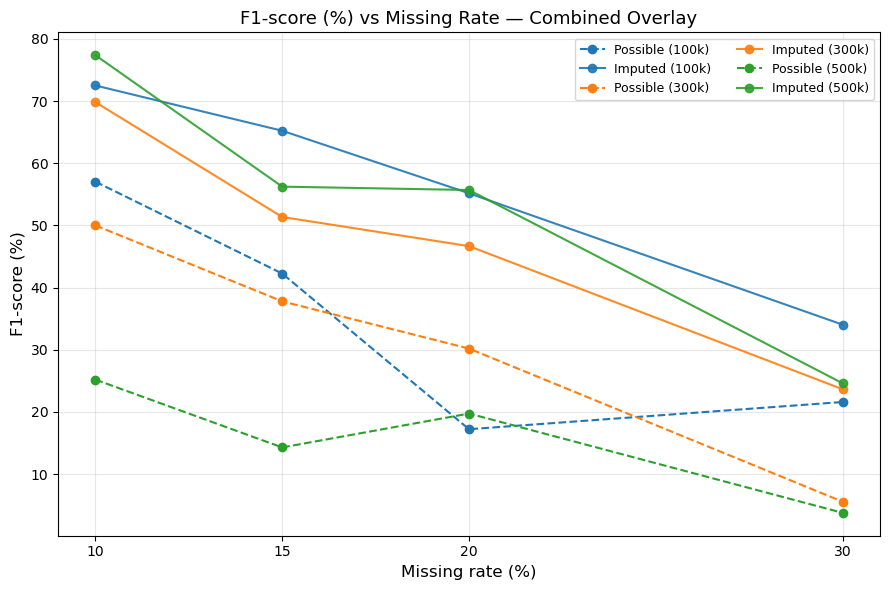

✅ Saved chart → /home/jovyan/output/original/logs/chart_bounded/combined_overlay_jaccard.png


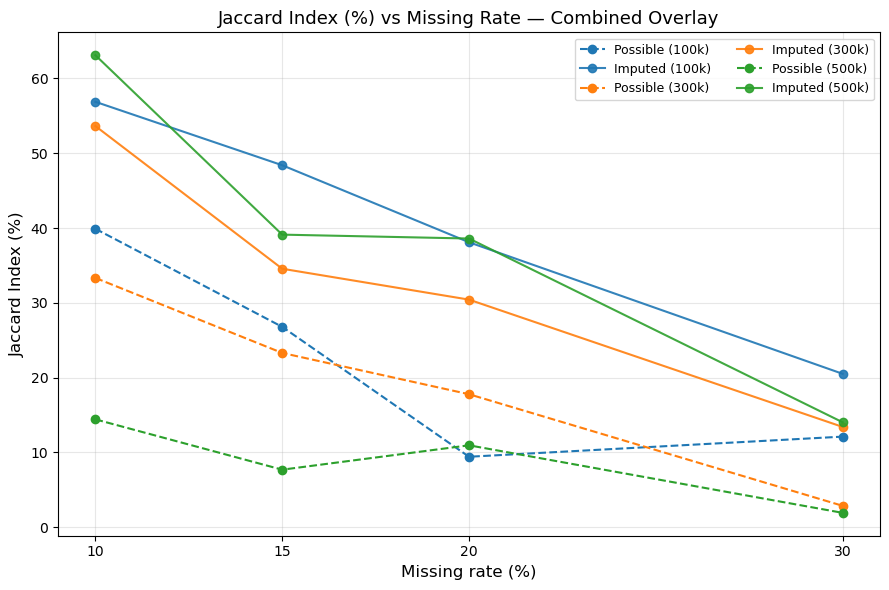


🎉 Charts saved to: /home/jovyan/output/original/logs/chart_bounded


In [11]:
# ============================================================
# 📊 Combined Overlay Chart — F1 & Jaccard (no shaded area)
#  ✅ Hiển thị trực tiếp + Lưu file PNG vào /home/jovyan/output/original/logs/chart_bounded
#  ✅ Khớp flow hiện tại: dùng possible CSV mới (_flights) + imputed CSV hiện có
# ============================================================
import os
import pandas as pd
import matplotlib.pyplot as plt

# -------- Directories --------
BASE_LOG = "/home/jovyan/output/original/logs"
# Possible (đã đổi đúng tên file theo flow hiện tại)
CSV_POSSIBLE = os.path.join(BASE_LOG, "skyline_possible_vs_true_percent_flights.csv")
# Imputed
CSV_IMPUTED  = os.path.join(BASE_LOG, "skyline_eval_imputed_vs_true_percent.csv")
OUT_DIR = os.path.join(BASE_LOG, "chart_bounded")
os.makedirs(OUT_DIR, exist_ok=True)

# -------- Load CSVs & normalize columns --------
def load_csv(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Không tìm thấy file CSV: {path}")
    df = pd.read_csv(path)
    # Chuẩn hóa tên cột
    df.columns = [c.strip().lower() for c in df.columns]
    # Thống nhất tên cột miss_rate_pct
    if "miss_rate_pct" not in df.columns:
        for k in ["rate", "missing_rate", "missing_rate_pct", "miss_rate"]:
            if k in df.columns:
                df = df.rename(columns={k: "miss_rate_pct"})
                break
    # Thống nhất tên cột F1 & Jaccard
    rename_map = {
        "f1_pct": "f1_percent",
        "jaccard_pct": "jaccard_percent",
        "precision_pct": "precision_percent",
        "recall_pct": "recall_percent"
    }
    for old, new in rename_map.items():
        if old in df.columns and new not in df.columns:
            df = df.rename(columns={old: new})
    # Ép kiểu số (nếu lỡ ghi ở dạng string)
    for c in ["miss_rate_pct", "f1_percent", "jaccard_percent", "precision_percent", "recall_percent"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    # size là string (vd "100k")
    if "size" in df.columns:
        df["size"] = df["size"].astype(str).str.strip().str.lower()
    return df

df_pos = load_csv(CSV_POSSIBLE)
df_imp = load_csv(CSV_IMPUTED)

# Chuẩn hóa size keys về cùng format: "100k", "300k", "500k"
def normalize_size_values(df):
    if "size" not in df.columns:
        return df
    df["size"] = df["size"].str.replace(" ", "", regex=False).str.lower()
    # một số log có thể ghi "100K" → "100k"
    df["size"] = df["size"].str.replace("k", "k", regex=False)
    return df

df_pos = normalize_size_values(df_pos)
df_imp = normalize_size_values(df_imp)

sizes = ["100k", "300k", "500k"]
rate_order = [10, 15, 20, 30]

# -------- Color palette --------
palette = {
    "100k": "#1f77b4",  # blue
    "300k": "#ff7f0e",  # orange
    "500k": "#2ca02c",  # green
}

# -------- Function to plot overlay & save --------
def overlay_plot(metric_col, ylabel, fname):
    plt.figure(figsize=(9,6))

    for sz in sizes:
        # Lọc theo size & các rate mong muốn
        p = df_pos[(df_pos.get("size", "") == sz) & (df_pos["miss_rate_pct"].isin(rate_order))][["miss_rate_pct", metric_col]]
        i = df_imp[(df_imp.get("size", "") == sz) & (df_imp["miss_rate_pct"].isin(rate_order))][["miss_rate_pct", metric_col]]

        # Đề phòng thiếu cột metric do CSV cũ: bỏ qua nếu không có
        if metric_col not in p.columns or metric_col not in i.columns:
            print(f"[⚠] Thiếu cột {metric_col} trong CSV cho size={sz}. Bỏ qua.")
            continue

        # Merge theo miss_rate_pct
        mg = pd.merge(
            p.rename(columns={metric_col: "possible"}),
            i.rename(columns={metric_col: "imputed"}),
            on="miss_rate_pct",
            how="inner"
        ).sort_values("miss_rate_pct")

        if mg.empty:
            print(f"[⚠] Không có giao nhau miss_rate giữa Possible & Imputed cho {sz} - {metric_col}")
            continue

        x = mg["miss_rate_pct"].values
        yU = mg["possible"].values
        yM = mg["imputed"].values
        c = palette[sz]

        # Plot lines: Possible (dashed) & Imputed (solid)
        plt.plot(x, yU, "o--", color=c, label=f"Possible ({sz})")
        plt.plot(x, yM, "o-",  color=c, alpha=0.9, label=f"Imputed ({sz})")

    plt.xlabel("Missing rate (%)", fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(f"{ylabel} vs Missing Rate — Combined Overlay", fontsize=13)
    plt.xticks(rate_order)
    plt.grid(alpha=0.3)
    plt.legend(ncol=2, fontsize=9, loc="best")
    plt.tight_layout()

    # ✅ Save figure
    out_path = os.path.join(OUT_DIR, fname)
    plt.savefig(out_path, dpi=200)
    print(f"✅ Saved chart → {out_path}")

    # ✅ Show on Jupyter
    plt.show()

# -------- Generate & display both charts --------
overlay_plot("f1_percent", "F1-score (%)", "combined_overlay_f1.png")
overlay_plot("jaccard_percent", "Jaccard Index (%)", "combined_overlay_jaccard.png")

print("\n🎉 Charts saved to:", OUT_DIR)